## BIOINFORMATICS THESIS: MULTIMODAL NEURAL NETWORK

# CELL LINE: A549

In [1]:
import pandas as pd 
import numpy as np
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict, OrderedDict
import pickle

import sqlite3
from sqlalchemy import create_engine

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from BIOINF_tesi.data_pipe import CELL_LINES, TASKS

In [3]:
from BIOINF_tesi.data_pipe import Load_Create_Task
from BIOINF_tesi.data_pipe import Build_DataLoader_Pipeline

In [4]:
from BIOINF_tesi.models import FFNN, CNN, CNN_LSTM
from BIOINF_tesi.models.utils import fit, Param_Search, Kfold_CV

In [5]:
with open ('results_dict.pickle', 'rb') as fin:
    results_dict = pickle.load(fin)
    results_dict = defaultdict(lambda: defaultdict(dict), results_dict)

In [6]:
from BIOINF_tesi.visual import print_content_results_dict

In [7]:
print_content_results_dict('EmbraceNetMultimodal_augm')

A549

active_E_vs_inactive_E
EmbraceNetMultimodal_augm

active_P_vs_inactive_P
EmbraceNetMultimodal_augm

active_E_vs_active_P
EmbraceNetMultimodal_augm

inactive_E_vs_inactive_P
EmbraceNetMultimodal_augm

active_EP_vs_inactive_rest
EmbraceNetMultimodal_augm


GM12878

active_E_vs_inactive_E
EmbraceNetMultimodal_augm

active_P_vs_inactive_P
EmbraceNetMultimodal_augm

active_E_vs_active_P
EmbraceNetMultimodal_augm

inactive_E_vs_inactive_P
EmbraceNetMultimodal_augm

active_EP_vs_inactive_rest
EmbraceNetMultimodal_augm


H1

active_E_vs_inactive_E
EmbraceNetMultimodal_augm

active_P_vs_inactive_P
EmbraceNetMultimodal_augm

active_E_vs_active_P
EmbraceNetMultimodal_augm

inactive_E_vs_inactive_P
EmbraceNetMultimodal_augm

active_EP_vs_inactive_rest
EmbraceNetMultimodal_augm


HEK293

active_E_vs_inactive_E
EmbraceNetMultimodal_augm

active_P_vs_inactive_P
EmbraceNetMultimodal_augm

active_E_vs_active_P
EmbraceNetMultimodal_augm

inactive_E_vs_inactive_P
EmbraceNetMultimodal_augm

active_E

---

In [9]:
from BIOINF_tesi.visual import get_average_AUPRC_df

df = get_average_AUPRC_df(models=['FFNN','CNN','EmbraceNetMultimodal','ConcatNetMultimodal',
                                 'EmbraceNetMultimodal_augm'])

for model in df.keys():
    print(model)
    display(df[model])

FFNN


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.12792,0.24045,0.6767,0.57161,0.20654
GM12878,0.41504,0.34183,0.84293,0.57068,0.33679
H1,0.10707,0.25076,0.55682,0.57934,0.20899
HEK293,0.16061,0.31227,0.81008,0.57137,0.24144
HEPG2,0.28586,0.35415,0.77376,0.59477,0.31254
K562,0.16987,0.35191,0.80136,0.57487,0.21239
MCF7,0.13679,0.32739,0.76352,0.57257,0.21045


CNN


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.06011,0.19374,0.65774,0.58422,0.14678
GM12878,0.20147,0.23723,0.78504,0.55978,0.20721
H1,0.08377,0.20219,0.33909,0.5997,0.19009
HEK293,0.11423,0.24028,0.60146,0.45543,0.20859
HEPG2,0.12415,0.24769,0.68355,0.57477,0.19717
K562,0.09604,0.24245,0.64967,0.56412,0.16921
MCF7,0.08775,0.19941,0.55164,0.45291,0.17418


EmbraceNetMultimodal


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.09301,0.18169,0.68973,0.57851,0.15695
GM12878,0.39003,0.23404,0.74794,0.56198,0.27255
H1,0.08783,0.29423,0.40921,0.58471,0.23451
HEK293,0.12506,0.24603,0.78331,0.58511,0.20273
HEPG2,0.12313,0.28192,0.57915,0.57384,0.17412
K562,0.10981,0.33587,0.76434,0.57377,0.17803
MCF7,0.08383,0.25756,0.54421,0.59234,0.17586


ConcatNetMultimodal


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.07598,0.21349,0.69375,0.59152,0.17485
GM12878,0.34071,0.24199,0.73271,0.54756,0.32124
H1,0.0948,0.2321,0.33734,0.58151,0.22755
HEK293,0.12869,0.24035,0.74639,0.58561,0.17691
HEPG2,0.18464,0.2446,0.6616,0.59477,0.25679
K562,0.11477,0.31197,0.63634,0.59153,0.22964
MCF7,0.08323,0.2504,0.76525,0.59242,0.24137


EmbraceNetMultimodal_augm


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.09038,0.20377,0.67142,0.58066,0.20766
GM12878,0.26883,0.27028,0.67502,0.56361,0.31847
H1,0.15266,0.24426,0.29897,NaN,NaN
HEK293,0.12528,0.23461,0.8063,NaN,NaN
HEPG2,NaN,NaN,NaN,NaN,NaN
K562,NaN,NaN,NaN,NaN,NaN
MCF7,NaN,NaN,NaN,NaN,NaN


---

In [8]:
from BIOINF_tesi.visual import plot_scores
from BIOINF_tesi.data_pipe import CELL_LINES, TASKS

## 1) A549

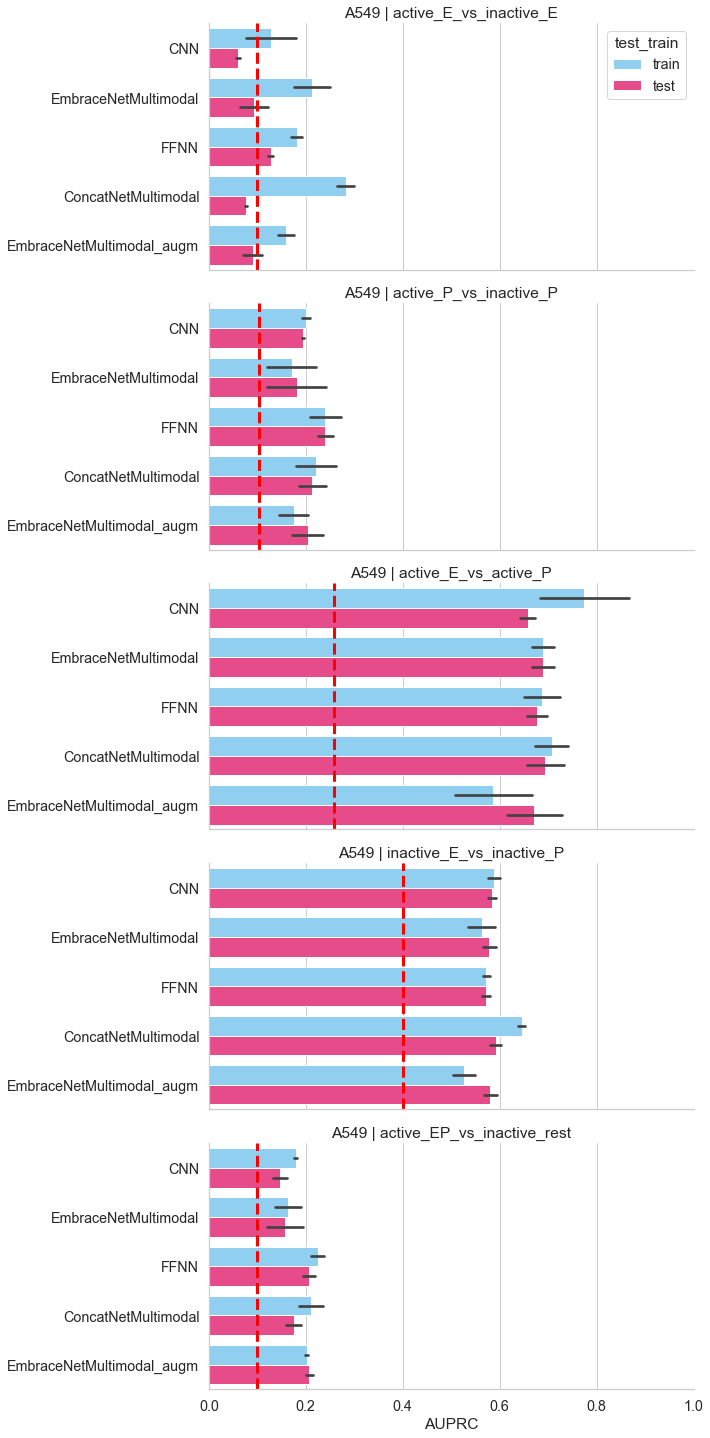

In [11]:
cell_line = CELL_LINES[0]
plot_scores(cells=cell_line, 
            models=['FFNN','CNN', 'EmbraceNetMultimodal', 'ConcatNetMultimodal', 'EmbraceNetMultimodal_augm'],
            palette=0)

## 2) GM12878

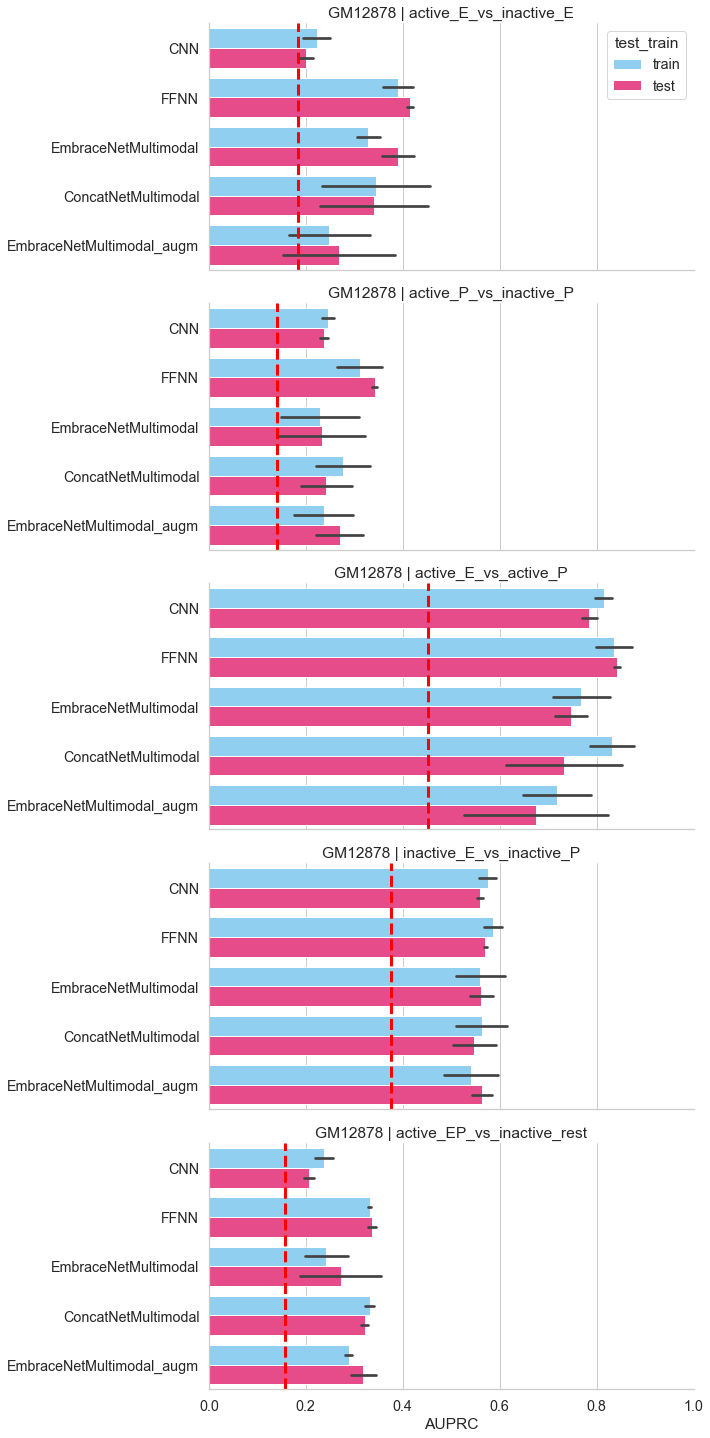

In [11]:
cell_line = CELL_LINES[1]
plot_scores(cells=cell_line, 
            models=['FFNN','CNN', 'EmbraceNetMultimodal', 'ConcatNetMultimodal', 'EmbraceNetMultimodal_augm'], 
            palette=0)

## 3) H1

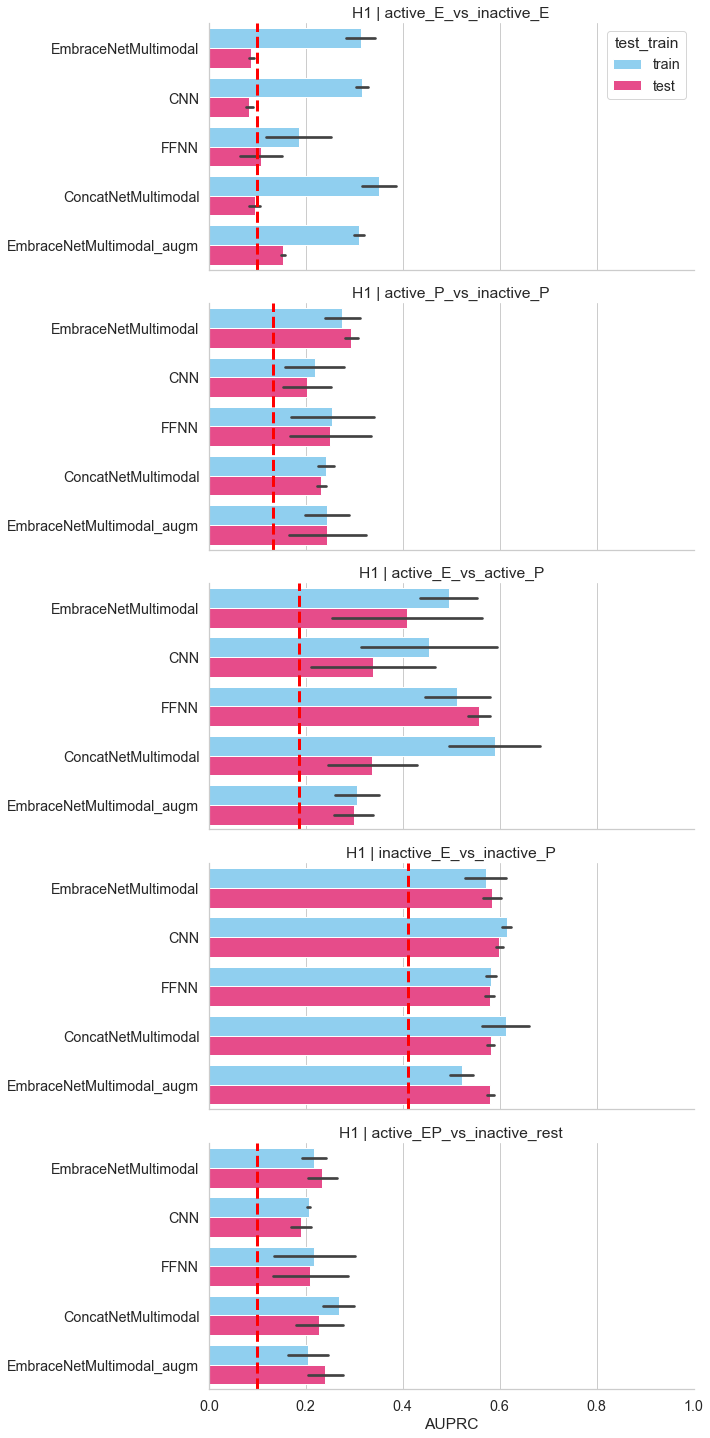

In [12]:
cell_line = CELL_LINES[2]
plot_scores(cells=cell_line, 
            models=['FFNN','CNN', 'EmbraceNetMultimodal', 'ConcatNetMultimodal', 'EmbraceNetMultimodal_augm'], 
            palette=0)

## 4) HEK293

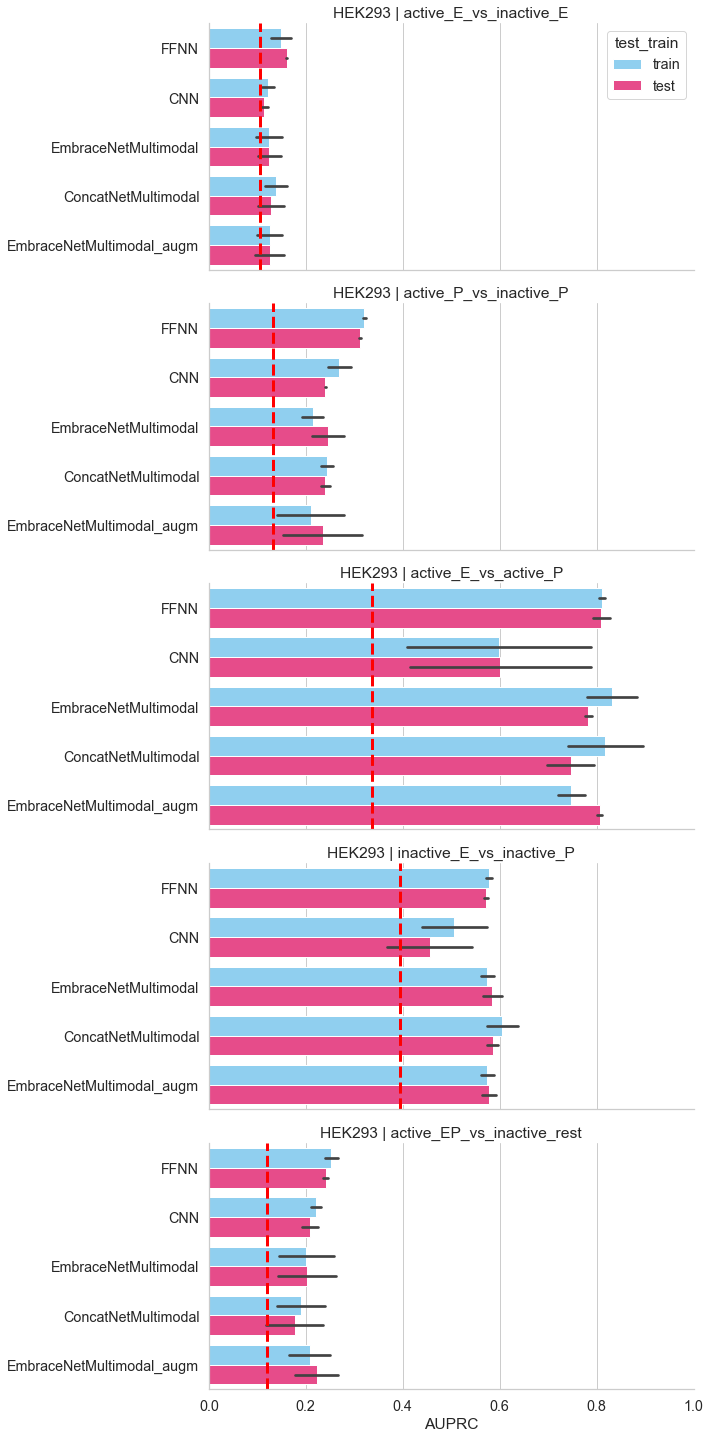

In [13]:
cell_line = CELL_LINES[3]
plot_scores(cells=cell_line, 
            models=['FFNN','CNN', 'EmbraceNetMultimodal', 'ConcatNetMultimodal', 'EmbraceNetMultimodal_augm'], 
            palette=0)

## 5) HEPG2

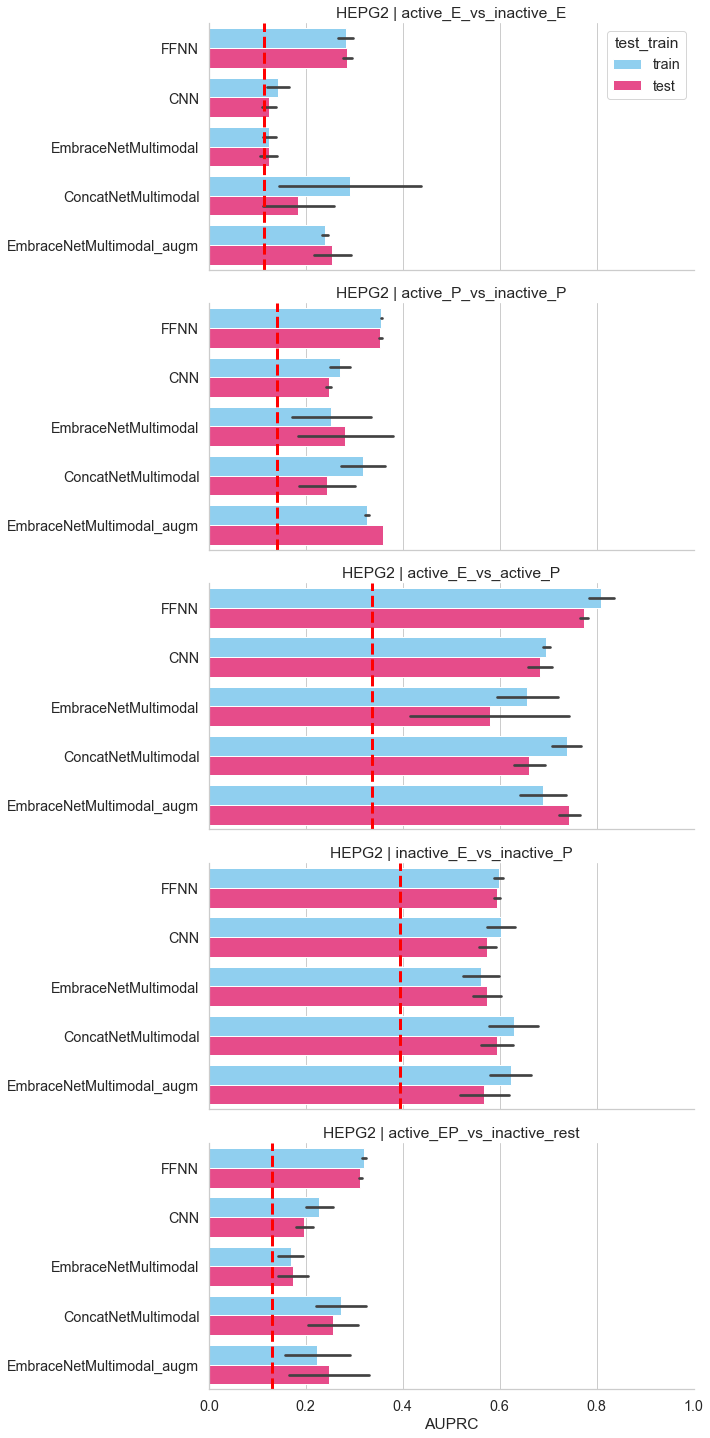

In [14]:
cell_line = CELL_LINES[4]
plot_scores(cells=cell_line, 
            models=['FFNN','CNN', 'EmbraceNetMultimodal', 'ConcatNetMultimodal', 'EmbraceNetMultimodal_augm'], 
            palette=0)

## 6) K562

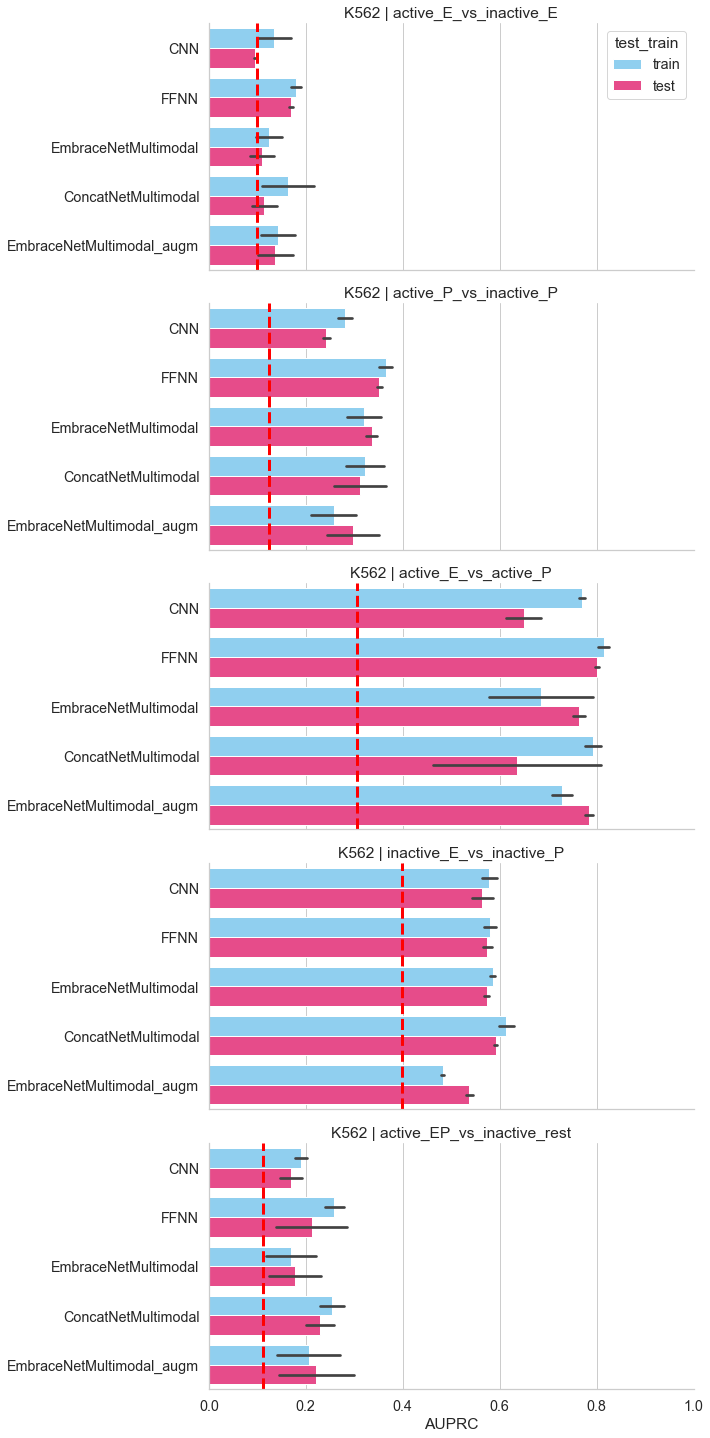

In [15]:
cell_line = CELL_LINES[5]
plot_scores(cells=cell_line, 
            models=['FFNN','CNN', 'EmbraceNetMultimodal', 'ConcatNetMultimodal', 'EmbraceNetMultimodal_augm'], 
            palette=0)

## 7) MCF7

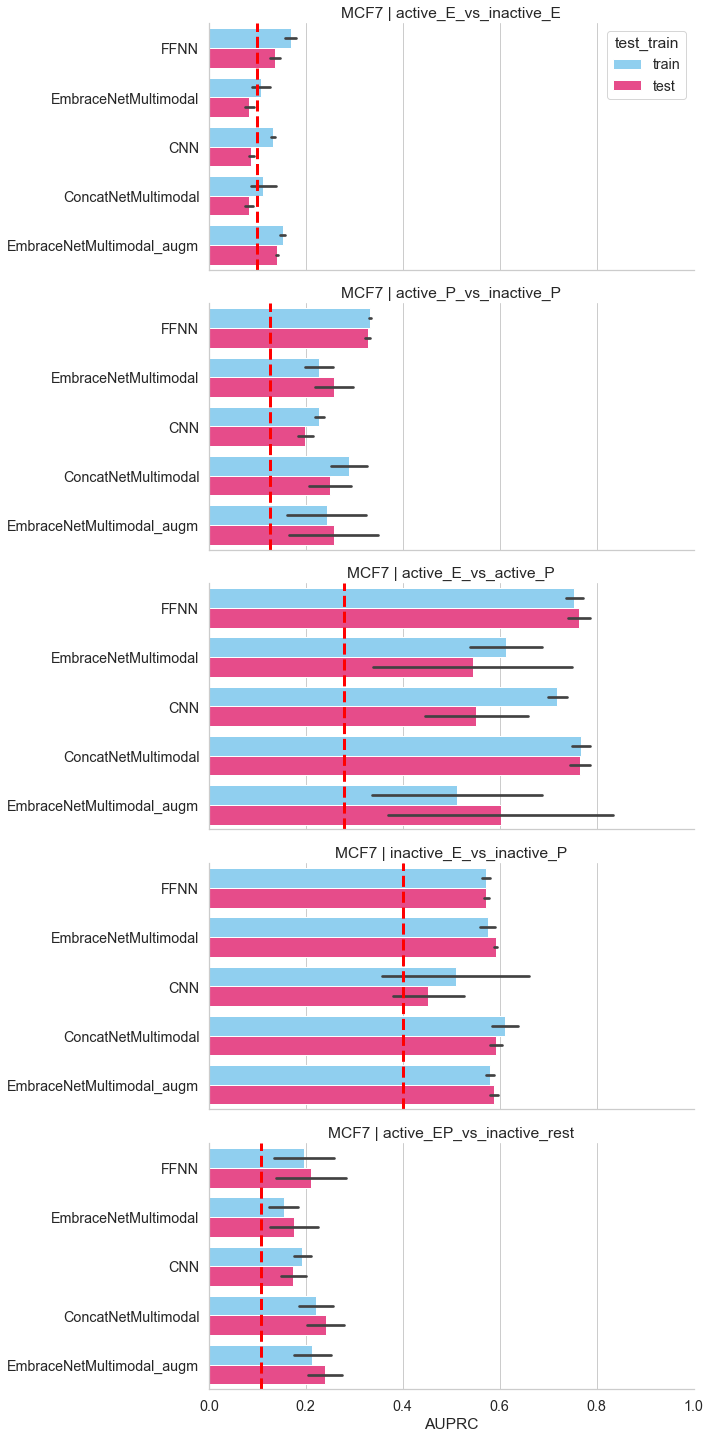

In [16]:
cell_line = CELL_LINES[6]
plot_scores(cells=cell_line, 
            models=['FFNN','CNN', 'EmbraceNetMultimodal', 'ConcatNetMultimodal', 'EmbraceNetMultimodal_augm'], 
            palette=0)

---

In [ ]:
from BIOINF_tesi.visual import Compare_Models_Result
#import warnings
#warnings.filterwarnings("ignore")

compare_models = Compare_Models_Result()
pval_dict = compare_models(device)

Iter tasks:   0%|          | 0/5 [00:00<?, ?it/s]

Data Preprocessing Done!


Iter cell lines:   0%|          | 0/7 [00:00<?, ?it/s]

Iter models:   0%|          | 0/5 [00:00<?, ?it/s]

Iter models:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
with open ('pval_results_dict.pickle', 'wb') as fout:
    pickle.dump(OrderedDict(pval_dict), fout)